In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import random
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

In [94]:
# Read csv file, convert time to datetime data type, create persistance model
df = pd.read_csv("flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)

In [95]:
persistanceForecast = []
realLoads = []

targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
for name in targetColumns:
    df[name + "_7day_pers"] = df[name].shift(336, axis=0)
    persistanceForecast.append(np.split(df[name + "_7day_pers"].values, [7247,8687])[1])
    realLoads.append(np.split(df[name].values, [7247,8687])[1])

persistanceForecast = np.asarray(persistanceForecast)
realLoads = np.asarray(realLoads)

peakLoads = np.loadtxt("../Final/peakLoads.txt")
triggers = peakLoads * 0.4


#data = persistanceForecast.reshape(persistanceForecast.shape[0], persistanceForecast.shape[1] // 48, 48)
#realLoads = realLoads.reshape(realLoads.shape[0], realLoads.shape[1] // 48, 48)

In [96]:
MAE = []
MAPE = []

for i in range(18):
    MAE.append(mean_absolute_error(realLoads[i], persistanceForecast[i]))
    MAPE.append(mean_absolute_percentage_error(realLoads[i], persistanceForecast[i]))

In [97]:
# for i in range(18):
#     print(MAE[i])

# print("\n")

# for i in range(18):
#     print(MAPE[i])

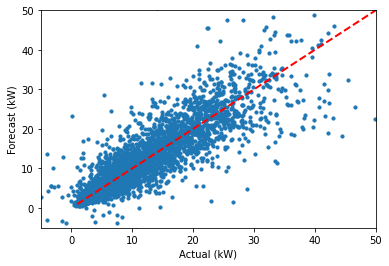

In [98]:
my_randoms = random.sample(range(1440*18), 4000)
plt.scatter((realLoads.flatten())[my_randoms], (persistanceForecast.flatten())[my_randoms],s=10)
plt.plot([1,60], [1,60], c="r",ls="--",linewidth=2)
plt.xlabel("Actual (kW)")
plt.ylabel("Forecast (kW)")
ax = plt.gca()
# for axis in ['top','right']:
#   ax.spines[axis].set_linewidth(0)
ax.set_xlim([-5, 50])
ax.set_ylim([-5, 50])
plt.savefig("persistanceCompare.svg", format='svg', dpi=1500, bbox_inches="tight")

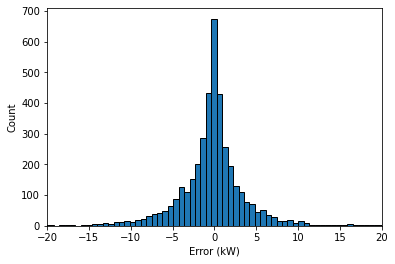

In [99]:
error = (realLoads.flatten())[my_randoms] - (persistanceForecast.flatten())[my_randoms]

plt.hist(error, bins="stone", edgecolor='black', linewidth=1)
plt.xlabel("Error (kW)")
plt.ylabel("Count")
ax = plt.gca()

# for axis in ['top','right']:
#   ax.spines[axis].set_linewidth(0)

ax.set_xlim([-20, 20])
# ax.set_ylim([-5, 50])


plt.savefig("persistanceErrors.svg", format='svg', dpi=1500, bbox_inches="tight")

In [100]:
x = list(range(-20, 21, 1))

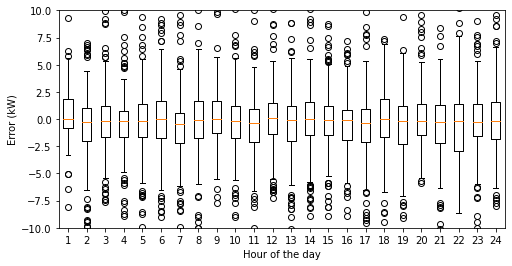

In [101]:
box_data =[]

for i in range(0,24):
    x = error[i*2::48]
    y = error[i*2-1::48]
    box_data.append(np.concatenate((x,y)))


fig, axs = plt.subplots(1)
axs.boxplot(box_data)
axs.set_xlabel("Hour of the day")
axs.set_ylabel("Error (kW)")
#ax = plt.gca()


# ax.set_xlim([-20, 20])
axs.set_ylim([-10, 10])
#axs.set_yticks(fontsize=13)
#axs.set_xticks(fontsize=13)
# fig.set_figheight(8)
fig.set_figwidth(8)
plt.savefig("boxplot.jpg", dpi=300)
plt.show()

In [102]:
realLoadTemp = np.reshape(realLoads, (18, 1440))
errors = abs(realLoadTemp - persistanceForecast)  

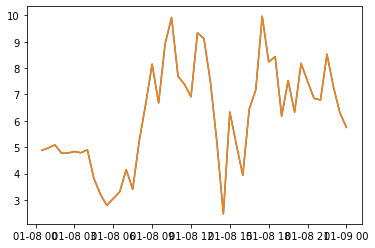

In [103]:
l = 0
h = 48

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], persistanceForecast[0][l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], df[targetColumns[0]].iloc[l+7247-336:h+7247-336], label="Forecast")

In [104]:
class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(peakLoads.shape[0]):
    batteries.append(Battery(peakLoads[i]))

In [105]:
temp = np.asarray(realLoads)
data = np.empty((18,30,48))
realLoads = np.empty((18,30,48))
for feeder in range(data.shape[0]):
    for day in range(data.shape[1]):
        for hour in range(data.shape[2]):
            data[feeder][day][hour] = persistanceForecast[feeder][day*48 + hour]
            realLoads[feeder][day][hour] = temp[feeder][day*48 + hour]

In [106]:
isCharging = np.empty((18,30,48))

for feeder in range(data.shape[0]):
    chargeRate = batteries[feeder].maxChargeRate
    dischargeRate = batteries[feeder].maxDischargeRate
    maxSOC = batteries[feeder].maxSOC

    for day in range(data.shape[1]):
        diff = triggers[feeder] - data[feeder][day]
        for hour, value in enumerate(diff):
            if value >= 0:
                isCharging[feeder][day][hour] = chargeRate
            else:
                isCharging[feeder][day][hour] = -dischargeRate



In [107]:
newSOC = np.empty((18,30,48))
newChargeRate = np.empty((18,30,48))
gridImport = np.empty((18,30,48))

for feeder in range(newSOC.shape[0]):
    for day in range(newSOC.shape[1]):
        for hour in range(newSOC.shape[2]):
            if hour == 0:
                newChargeRate[feeder][day][hour] = 0
                newSOC[feeder][day][hour] = 0
            else:
                newSOC[feeder][day][hour] = newSOC[feeder][day][hour-1] + isCharging[feeder][day][hour]
                if newSOC[feeder][day][hour] > batteries[feeder].maxSOC:
                    # Assume extra charge is simply wasted
                    newChargeRate[feeder][day][hour] = isCharging[feeder][day][hour]
                    newSOC[feeder][day][hour] = batteries[feeder].maxSOC
                elif newSOC[feeder][day][hour] < 0:
                    # Charge less than zero must be accounted for
                    newChargeRate[feeder][day][hour] = isCharging[feeder][day][hour] - newSOC[feeder][day][hour]
                    newSOC[feeder][day][hour] = 0
                else:
                    newChargeRate[feeder][day][hour] = isCharging[feeder][day][hour]
            
            gridImport[feeder][day][hour] = realLoads[feeder][day][hour] + 2*newChargeRate[feeder][day][hour]

In [108]:
peakChangeRatio = []

for feeder in range(gridImport.shape[0]):
    realLoadsMax = []
    batteryLoadsMax = []
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))
    peakChangeRatio.append(np.mean(np.divide(batteryLoadsMax, realLoadsMax)))

# Value > 1 means peak is decreasing, < 1 means peak is increasing
percentReduction = (1-np.asarray(peakChangeRatio)) * 100
np.mean(percentReduction)

-53.82275174771389

d:\Programs\Python\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


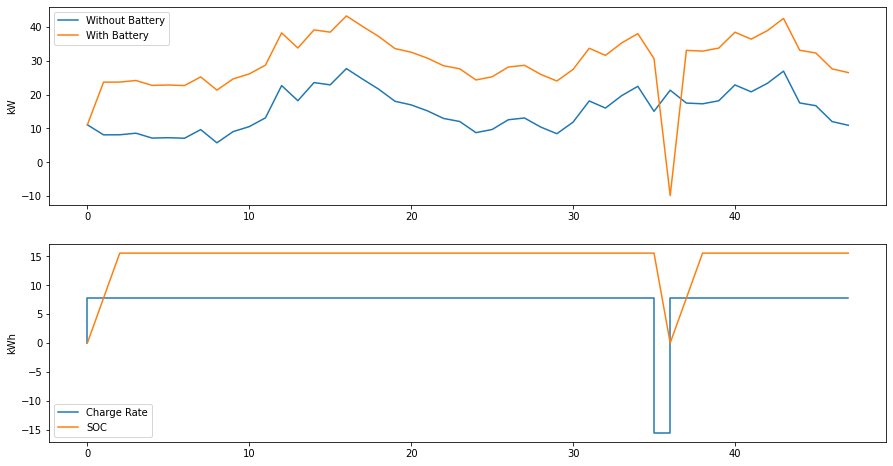

In [109]:
feeder = 9
day = 25

y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].plot(y,realLoads[feeder][day], label="Without Battery")
axs[0].plot(y,gridImport[feeder][day], label="With Battery")
#axs[0].plot(y,filter_data[0][0], label="filter data")
axs[0].legend()
axs[0].set_ylabel("kW")
axs[1].step(y,newChargeRate[feeder][day], label="Charge Rate")
axs[1].plot(y,newSOC[feeder][day],label="SOC")
axs[1].legend()
axs[1].set_ylabel("kWh")

fig.set_figheight(8)
fig.set_figwidth(15)
fig.show()

In [110]:
realLoadsMax = []
batteryLoadsMax = []

for feeder in range(gridImport.shape[0]):
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))

# Value > 1 means peak is decreasing, < 1 means peak is increasing
peakChangeRatio = np.divide(realLoadsMax, batteryLoadsMax)
np.mean(peakChangeRatio)

0.6601004200916535

In [111]:
# Limit where battery charge will toggle
trigger = 15
chargeRate = 5
dischargeRate = -9
battChargeInst = 0
battCapacity = 30   # kWh
effi = 0.96
loss = 0.100
period = 0.5

battCharge = []
loadInst = 0
load = []
isCharging = []
# Capacity of battery, look into this more later
# diff > 0 charging, diff < 0 discharing
diff = trigger - pers

for i, x in enumerate(diff):
    if x > chargeRate:
        x = chargeRate
    elif x < dischargeRate:
        x = dischargeRate
    
    if x >= 0:
        battChargeInst += ((x * effi) - loss) * period
        isCharging.append(1)
    else:
        battChargeInst += ((x * (1/effi) - loss)) * period
        isCharging.append(0)
    loadInst = pers[i] + x
    
    if battChargeInst < 0:
        loadInst -= battChargeInst
        battChargeInst = 0
    elif battChargeInst > battCapacity:
        loadInst -= battChargeInst - battCapacity
        battChargeInst = battCapacity
        
    battCharge.append(battChargeInst)
    load.append(loadInst)

NameError: name 'pers' is not defined

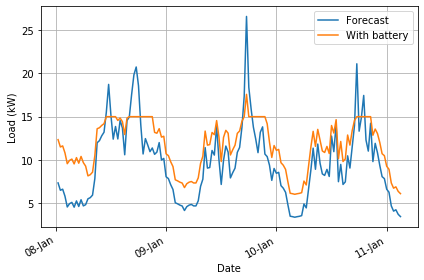

In [ ]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], pers[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_forecast_load.jpg", dpi=300, bbox_inches="tight")
plt.show()

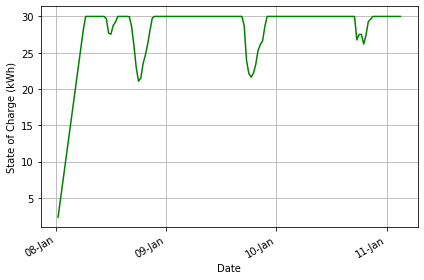

In [ ]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel("State of Charge (kWh)")
ax.set_xlabel("Date")
plt.tight_layout()
plt.savefig("battery_on_forecast_SoC.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Apply model to real loads
realLoads = df["crawfordCrescent_F2"].iloc[336:].values
battChargeInst = 0
battCharge = []
loadInst = 0
load = []

for index, isChargingInst in enumerate(isCharging):
    # Check if battery is scheduled to charge
    if isChargingInst:
        # Check if battery is full
        if battChargeInst > battCapacity:
            # If full, no charge is added and load is the same
            loadInst = realLoads[index]
        else:
            # If there's space in the battery, load will increase by the charge rate
            loadInst = realLoads[index] + chargeRate     
            battChargeInst += chargeRate
    else:
        if battChargeInst >= 0:
            loadInst = realLoads[index] + dischargeRate
            battChargeInst += dischargeRate
        else:
            loadInst = realLoads[index]
    if battChargeInst > battCapacity:
        battChargeInst = 50
    elif battChargeInst < 0:
        battChargeInst = 0
    load.append(loadInst)
    battCharge.append(battChargeInst)

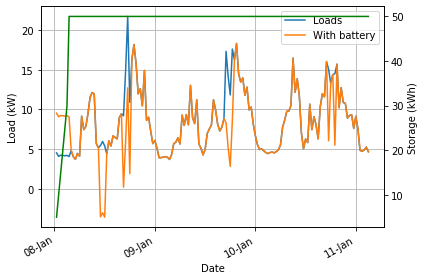

In [ ]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], realLoads[l:h], label="Loads")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")
ax2 = ax.twinx()
ax2.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax2.set_ylabel("Storage (kWh)")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_actual_load.jpg", dpi=300, bbox_inches="tight")
plt.show()